In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras import optimizers
from keras import regularizers
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/kaggle/input/audio-binary-classification/train_data.npy
/kaggle/input/audio-binary-classification/sample_submission.csv
/kaggle/input/audio-binary-classification/train_labels.csv
/kaggle/input/audio-binary-classification/test_data.npy


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
train_data = np.load('/kaggle/input/audio-binary-classification/train_data.npy');
test_data = np.load('/kaggle/input/audio-binary-classification/test_data.npy');


print("inputs loaded")

inputs loaded


44100


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


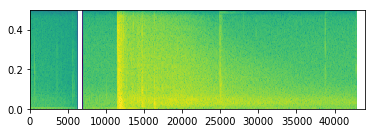

In [3]:
#Visualize data
audio_clip = train_data[3,:];
#print(audio_clip);
print(len(audio_clip));
#plt.plot(audio_clip);

f, t, Sxx = ss.spectrogram(audio_clip)

plt.plot(audio_clip);
plt.subplot(212);
plt.specgram(audio_clip,Fs=1.0);


In [4]:
#print(f)
#print(t)

fft_data = np.ones((len(f),len(t),3999))

for i in range(3999):
    f, t, Sxx = ss.spectrogram(train_data[i,:])
    fft_data[:,:,i] = Sxx;

fft_data_test = np.ones((len(f),len(t),3997))

for i in range(3997):
    f, t, Sxx = ss.spectrogram(test_data[i,:]);
    fft_data[:,:,i] = Sxx;
        

print(fft_data.shape)

(129, 196, 3999)


In [5]:
#Scale and Reshape
train_data = train_data.astype('float32');
test_data = test_data.astype('float32');

train_data = fft_data.reshape(-1,len(f),len(t),1);
test_data = fft_data_test.reshape(-1,len(f),len(t),1);

input_shape = train_data.shape;
print(input_shape);

(3999, 129, 196, 1)


In [6]:
#Look at CSV and store as array
train_labels = pd.read_csv("/kaggle/input/audio-binary-classification/train_labels.csv");
train_labels = train_labels.values;
train_labels = train_labels[:,1];
print(train_labels[:10]);
print(train_labels.shape)

[0 0 0 1 0 0 1 0 1 0]
(3999,)


In [7]:
# create convolution neural network
model = Sequential()
model.add(Conv2D(32, kernel_size=(10,10),
                 input_shape=(len(f),len(t),1), activation='relu'))
#model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(64, (8,8), activation='relu'))
#model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(5)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (5,5), activation='relu'))
#model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 187, 32)      3232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 93, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 93, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 86, 64)        131136    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 17, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 13, 128)        204928    
__________

In [8]:
#Compile model
sgd = optimizers.SGD(lr=.01);
model.compile(loss='MSE', 
              optimizer='sgd',
              metrics=['accuracy'])

In [9]:
history = model.fit(train_data,train_labels,
          batch_size=25,epochs=50,verbose=1)

Epoch 1/50
3999/3999 [==============================] - 6s 2ms/step - loss: 0.1400 - acc: 0.8677
Epoch 2/50
3999/3999 [==============================] - 3s 748us/step - loss: 0.1142 - acc: 0.8777
Epoch 3/50
3999/3999 [==============================] - 3s 740us/step - loss: 0.1133 - acc: 0.8780
Epoch 4/50
3999/3999 [==============================] - 3s 743us/step - loss: 0.1130 - acc: 0.8780
Epoch 5/50
3999/3999 [==============================] - 3s 744us/step - loss: 0.1136 - acc: 0.8780
Epoch 6/50
3999/3999 [==============================] - 3s 745us/step - loss: 0.1133 - acc: 0.8780
Epoch 7/50
3999/3999 [==============================] - 3s 738us/step - loss: 0.1131 - acc: 0.8780
Epoch 8/50
3999/3999 [==============================] - 3s 746us/step - loss: 0.1127 - acc: 0.8780
Epoch 9/50
3999/3999 [==============================] - 3s 738us/step - loss: 0.1136 - acc: 0.8780
Epoch 10/50
3999/3999 [==============================] - 3s 745us/step - loss: 0.1137 - acc: 0.8780
Epoch 11/50

In [10]:
Y_pred = model.predict(test_data);
print(Y_pred)
df_pred = pd.DataFrame(Y_pred);
df_pred.index.name = "Id"
df_pred = pd.DataFrame.rename(df_pred,columns={0:"Label"})
print(df_pred);
df_pred.to_csv("output.csv")

[[0.39133084]
 [0.39133063]
 [0.39133084]
 ...
 [0.39133066]
 [0.39133066]
 [0.39133066]]
         Label
Id            
0     0.391331
1     0.391331
2     0.391331
3     0.391331
4     0.391331
...        ...
3992  0.391331
3993  0.391331
3994  0.391331
3995  0.391331
3996  0.391331

[3997 rows x 1 columns]
